In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
data = pd.read_csv('/Users/antreasantoniou/Downloads/gate-evolve-output.csv')

In [129]:
def display_custom(df):
    # visualize using tabulate for ipython noteboooks
    from IPython.display import display

    # Assuming df is your DataFrame
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(
            df
        )

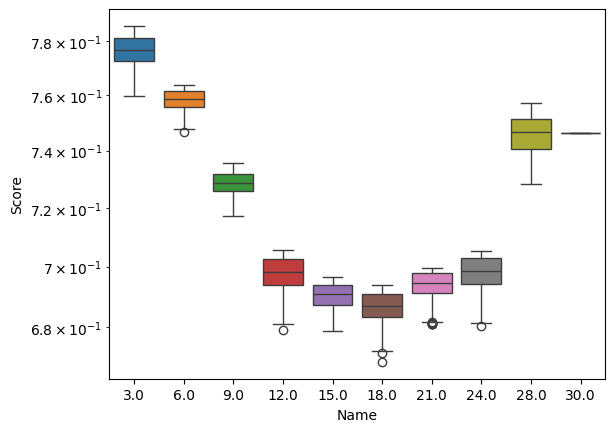

In [105]:
# Initialize a DataFrame to store the simulated data
sim_data = pd.DataFrame()

# For each row in the data, simulate a dataset and add it to sim_data
for idx, row in data.iterrows():
    # Use the normal distribution to simulate data
    if int(row["Name"]) > 2:
        simulated = np.random.normal(loc=row['mean_score'], scale=row['std_score'], size=1000)
        # Clip the simulated data at the min and max values
        simulated = np.clip(simulated, row['min_score'], row['max_score'])
        # Add the simulated data to the DataFrame
        sim_data[str(row['Name'])] = pd.Series(simulated)

# Plot a boxplot of the simulated data
# plt.figure(figsize=(10,6))
sns.boxplot(data=sim_data)
plt.xlabel('Name')
plt.ylabel('Score')
plt.yscale('log')
plt.show()


In [106]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create a Box trace for each row in the data
# Create a Box trace for each 'Name' in the data
# Initialize a DataFrame to store the simulated data
# Create a Box trace for each row in the data
# Create a Box trace for each 'Name' in the data


# Create traces for data points 1 and 2
traces_1_2 = []
for idx, row in data.iterrows():
    if int(row['Name']) <= 2:
        traces_1_2.append(go.Box(
            y=[row['min_score'], row['mean_score'] - row['std_score'], row['mean_score'], row['mean_score'] + row['std_score'], row['max_score']],
            name=int(row['Name']),
            boxpoints=False,
            line_width=2,
        ))

# Create traces for data points 3 and above
traces_3_plus = []
for idx, row in data.iterrows():
    if int(row['Name']) > 2:
        traces_3_plus.append(go.Box(
            y=[row['min_score'], row['mean_score'] - row['std_score'], row['mean_score'], row['mean_score'] + row['std_score'], row['max_score']],
            name=int(row['Name']),
            boxpoints=False,
            line_width=2,
        ))

# Create a figure with two subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("k=1, 2", "k>=3"))

# Add traces to the subplots
for trace in traces_1_2:
    fig.add_trace(trace, row=1, col=1)

for trace in traces_3_plus:
    fig.add_trace(trace, row=1, col=2)

# Update the layout
fig.update_layout(
    # title_text="Mean Squared Error for Different Number of Datasets (k)",
    
    yaxis_title='MSE',
    # xaxis_title='k (num datasets)',
    width=900,  # Width of the figure in pixels
    # height=400,  # Height of the figure in pixels
    autosize=False,
    showlegend=False,
    margin=dict(l=0, r=10, t=50, b=50),
    font=dict(
        family="Arial",  # Font family
        size=20,  # Font size
    ),
    # yaxis=dict(
    #     title_font=dict(
    #         size=14,  # Y-axis title font size
    #     ),
    #     tickfont=dict(
    #         size=12,  # Y-axis tick font size
    #     ),
    # ),
    # xaxis=dict(
    #     tickfont=dict(
    #         size=12,  # X-axis tick font size
    #     ),
    # ),
)
# Save the figure as a PDF
fig.write_image("boxplots.pdf")
fig.show()




In [107]:
import pandas as pd
import plotly.express as px

# Load the data from the CSV file
data = pd.read_csv('k=12-1.csv')

# Calculate the difference from 'full' variant
full_score = data[data['Name'] == 'full']['Score'].values[0]
data['Score Difference'] = data['Score'] - full_score
font_size = 18
# Create a line chart with markers using Plotly
fig = px.bar(data, x='Name', y='Score Difference', labels={'Name': 'Dataset Name', 'Score Difference':'Score Difference (lower is better)'})
fig.update_layout(
    # height=300,
    width=500,
    showlegend=False,
    font=dict(size=font_size),  # Global font size
    yaxis=dict(
        title_font=dict(size=font_size),  # Y-axis title font size
        tickfont=dict(size=font_size),  # Y-axis tick font size
    ),
    xaxis=dict(
        title_font=dict(size=font_size),  # X-axis title font size (if any)
        tickfont=dict(size=font_size),  # X-axis tick font size
    ),
    # margin=dict(l=20, r=20, t=20, b=20),  # margins
    
)

# Save the figure as a PDF file
fig.write_image("figure.pdf")
# Show the figure
fig.show()

In [108]:
sub_gate_columns = data["Name"]

sub_gate_columns = sub_gate_columns[1:]
sub_gate_columns = ["newyorkercaptioncontest" if col == "nycc" else col for col in sub_gate_columns]
print(sub_gate_columns)


[
    'chexpert',
    'pascal',
    'places365',
    'imagenet1k',
    'ade20k',
    'ham10k',
    'kinetics',
    'clevr',
    'ucf',
    'food101',
    'newyorkercaptioncontest',
    'flickr30k'
]

In [130]:
import pathlib

def load_data_as_df(filepath):
    df = pd.read_csv(filepath)

    # Concatenating the header with the first row
    new_headers = [f"{col.split('.')[0]}.{df.iloc[0][idx]}" for idx, col in enumerate(df.columns)]

    # Setting the new concatenated values as column names
    df.columns = new_headers

    # Removing the first row from the DataFrame
    df = df.drop(df.index[0])

    # Resetting the DataFrame index
    df.reset_index(drop=True, inplace=True)
    
    columns = df.columns.tolist()[1:]
    model_names = df.columns.tolist()[0]
    # remove all datapoints with less than 50% on imagenet1k.1


    # model_names = df[model_names][1:]

    # Convert all columns (except the first) to numeric
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        
    return df

source_csv_filepath = (
    "13032024-full.csv"
)
source_csv_filepath = pathlib.Path(source_csv_filepath)

df = load_data_as_df(source_csv_filepath)
display_custom(df)


/var/folders/gh/_5t3nhn94t12m7rh483b8b7r0000gn/T/ipykernel_62569/2170786204.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



,Model.Metric,cityscapes.mIoU,cityscapes.dice-loss,acdc.dice-loss,ade20k.mIoU,ade20k.dice-loss,aircraft.acc@1,chexpert.auc,cifar100.loss,cifar100.acc@5,cifar100.acc@1,clevr.acc@1,clevr-math.acc@5,clevr-math.acc@1,coco-10k.mIoU,coco-10k.dice-loss,coco-164k.mIoU,coco-164k.dice-loss,cubirds.acc@1,diabetic.auc,dtextures.acc@1,flickr30k.text-to-image-acc@5,flickr30k.text-to-image-acc@1,flickr30k.image-to-text-acc@1,flickr30k.image-to-text-acc@5,food101.loss,food101.acc@5,food101.acc@1,fungi.acc@1,ham10k.auc,hmdb51.acc@5,hmdb51.acc@1,imagenet1k.loss,imagenet1k.acc@5,imagenet1k.acc@1,iwildcam.mae,kinetics.acc@5,kinetics.acc@1,mini.acc@1,newyorkercaptioncontest.text-to-image-acc@5,newyorkercaptioncontest.text-to-image-acc@1,newyorkercaptioncontest.image-to-text-acc@1,newyorkercaptioncontest.image-to-text-acc@5,nyu.mIoU,nyu.dice-loss,omniglot.acc@1,pascal.mIoU,pascal.dice-loss,places365.loss,places365.acc@5,places365.acc@1,pokemonblipcaptions.text-to-image-acc@5,pokemonblipcaptions.text-to-image-acc@1,pokemonblipcaptions.image-to-text-acc@1,pokemonblipcaptions.image-to-text-acc@5,ucf.acc@5,ucf.acc@1,vgg.acc@1,winoground.text-to-image-acc@1,winoground.image-to-text-acc@1
0,AR-ViT-B16-224,57.848,0.6481,0.571,17.353,0.777,0.944,0.813,1.636,83.629,55.742,52.828,98.850,58.849,22.783,0.973,21.321,0.970,0.944,0.839,0.799,0.188,0.053,0.055,0.187,0.582,96.630,83.834,0.775,0.985,57.917,28.385,0.967,93.007,78.199,4.093,63.288,36.718,0.987,0.195,0.052,0.054,0.187,8.345,0.271,0.986,15.460,0.781,2.062,78.706,46.641,0.821,0.640,0.628,0.794,84.369,65.374,0.955,0.569,0.611
1,BART,0.000,NaN,0.747,0.380,0.668,0.530,0.637,3.985,29.170,8.967,42.563,96.450,41.761,0.056,0.959,0.110,0.965,0.503,0.551,0.354,0.079,0.016,0.015,0.078,3.889,31.844,11.504,0.337,0.859,9.961,1.953,6.622,3.107,0.713,4.489,1.277,0.256,0.373,0.081,0.016,0.016,0.081,4.893,0.240,0.841,1.002,0.556,5.248,11.058,2.953,0.748,0.556,0.556,0.694,5.444,1.031,0.594,0.477,0.488
2,BERT,0.000,NaN,0.959,0.360,0.670,0.590,0.662,3.685,38.137,14.520,42.593,97.400,44.265,0.055,0.962,0.096,0.966,0.474,0.576,0.376,0.081,0.016,0.015,0.083,3.499,42.442,18.191,0.328,0.911,9.766,1.953,6.473,4.616,1.173,4.576,1.269,0.233,0.396,0.082,0.015,0.016,0.085,5.503,0.241,0.902,0.961,0.545,5.008,16.037,4.795,0.756,0.599,0.587,0.722,6.040,1.287,0.594,0.504,0.503
3,CLIP-B16-224,65.142,0.5994,0.538,33.804,0.687,0.965,0.816,0.908,93.760,74.731,52.622,99.113,61.218,29.609,0.968,30.369,0.954,0.979,0.867,0.843,0.209,0.055,0.062,0.206,0.306,98.679,91.496,0.854,0.986,70.039,40.404,0.752,95.708,81.815,3.613,71.240,44.574,0.962,0.210,0.057,0.060,0.199,7.545,0.287,0.989,26.619,0.632,1.757,83.864,53.445,0.852,0.679,0.618,0.817,88.238,71.440,0.989,0.540,0.486
4,ConvNextV2-Base,62.341,0.5822,0.636,37.253,0.472,0.967,0.818,0.640,97.422,84.126,52.606,99.787,77.402,26.840,0.147,25.059,0.169,0.980,0.875,0.850,0.212,0.055,0.060,0.205,0.272,98.991,92.896,0.857,0.991,77.539,50.326,0.635,96.851,85.288,3.446,75.765,49.011,0.958,0.214,0.058,0.063,0.210,5.260,0.225,0.986,32.665,0.297,1.659,85.325,54.726,0.803,0.610,0.616,0.783,94.737,84.106,0.996,0.478,0.398
5,DINO-B16-224,60.224,0.6387,0.515,18.610,0.733,0.956,0.819,1.200,89.590,66.282,52.846,99.188,61.001,24.968,0.969,24.292,0.951,0.959,0.847,0.791,0.196,0.046,0.054,0.186,0.478,97.449,86.519,0.812,0.987,56.525,27.995,1.376,88.493,67.529,4.010,55.634,29.529,0.899,0.200,0.052,0.053,0.190,6.138,0.286,0.987,18.184,0.698,1.987,79.704,47.454,0.856,0.682,0.655,0.818,77.125,52.769,0.959,0.483,0.495
6,DeiT3-B16-224,62.833,0.6401,0.591,21.900,0.703,0.953,0.827,1.162,90.844,66.750,52.342,99.350,62.701,28.345,0.953,26.125,0.959,0.962,0.818,0.819,0.200,0.050,0.056,0.192,0.447,97.718,87.331,0.805,0.985,64.338,36.523,0.794,94.675,82.011,3.194,66.558,39.528,0.988,0.219,0.060,0.065,0.205,7.488,0.292,0.986,22.291,0.667,1.943,80.614,48.677,0.826,0.670,0.639,0.810,88.506,70.411,0.962,0.492,0.424
7,EffFormer-s0,2.492,NaN,0.730,9.801,0.662,0.775,0.800,3.478,43.571,16.511,45.115,98.700,53.862,13.995,0.903,13.549,0.865

In [124]:
column_names = list(df.columns)

print(column_names)

[
    'Model.Metric',
    'cityscapes.mIoU',
    'cityscapes.dice-loss',
    'acdc.dice-loss',
    'ade20k.mIoU',
    'ade20k.dice-loss',
    'aircraft.acc@1',
    'chexpert.auc',
    'cifar100.loss',
    'cifar100.acc@5',
    'cifar100.acc@1',
    'clevr.acc@1',
    'clevr-math.acc@5',
    'clevr-math.acc@1',
    'coco-10k.mIoU',
    'coco-10k.dice-loss',
    'coco-164k.mIoU',
    'coco-164k.dice-loss',
    'cubirds.acc@1',
    'diabetic.auc',
    'dtextures.acc@1',
    'flickr30k.text-to-image-acc@5',
    'flickr30k.text-to-image-acc@1',
    'flickr30k.image-to-text-acc@1',
    'flickr30k.image-to-text-acc@5',
    'food101.loss',
    'food101.acc@5',
    'food101.acc@1',
    'fungi.acc@1',
    'ham10k.auc',
    'hmdb51.acc@5',
    'hmdb51.acc@1',
    'imagenet1k.loss',
    'imagenet1k.acc@5',
    'imagenet1k.acc@1',
    'iwildcam.mae',
    'kinetics.acc@5',
    'kinetics.acc@1',
    'mini.acc@1',
    'newyorkercaptioncontest.text-to-image-acc@5',
    'newyorkercaptioncontest.text-to-image-acc@1',
    'newyorkercaptioncontest.image-to-text-acc@1',
    'newyorkercaptioncontest.image-to-text-acc@5',
    'nyu.mIoU',
    'nyu.dice-loss',
    'omniglot.acc@1',
    'pascal.mIoU',
    'pascal.dice-loss',
    'places365.loss',
    'places365.acc@5',
    'places365.acc@1',
    'pokemonblipcaptions.text-to-image-acc@5',
    'pokemonblipcaptions.text-to-image-acc@1',
    'pokemonblipcaptions.image-to-text-acc@1',
    'pokemonblipcaptions.image-to-text-acc@5',
    'ucf.acc@5',
    'ucf.acc@1',
    'vgg.acc@1',
    'winoground.text-to-image-acc@1',
    'winoground.image-to-text-acc@1'
]

In [131]:
from typing import List, Optional
import pandas as pd

def calculate_means(df, terms: Optional[List], prefix: Optional[str] = None):
    # Find the metrics that contain any of the terms
    if not terms:
        included_metrics = df.columns[1:]
    else:
        included_metrics = [col for col in df.columns if any(term in col for term in terms)]

    # Separate the metrics into "lower is better" and "higher is better"
    lower_is_better_metrics = [col for col in included_metrics if 'loss' in col or 'mae' in col]
    higher_is_better_metrics = list(set(included_metrics) - set(lower_is_better_metrics))
    print(lower_is_better_metrics)
    print(higher_is_better_metrics)
    # Convert fractional values to percentages in the higher_is_better_metrics, if necessary
    
    for col in higher_is_better_metrics:
        if df[col].max() < 1:  # Check if the column is in a fractional format
            df[col] = df[col] * 100  # Convert to percentage format
    if prefix is None:
        prefix = 'Mean'
    # Calculate the mean for lower and higher is better metrics
    df[f'{prefix} (Lower is better)'] = df[lower_is_better_metrics].mean(axis=1)
    df[f'{prefix} (Higher is better)'] = df[higher_is_better_metrics].mean(axis=1)

    return df

In [133]:
df = calculate_means(df, None, 'GATE')
df = calculate_means(df, sub_gate_columns, 'devGATE')

[
    'cityscapes.dice-loss',
    'acdc.dice-loss',
    'ade20k.dice-loss',
    'cifar100.loss',
    'coco-10k.dice-loss',
    'coco-164k.dice-loss',
    'food101.loss',
    'imagenet1k.loss',
    'iwildcam.mae',
    'nyu.dice-loss',
    'pascal.dice-loss',
    'places365.loss'
]

[
    'places365.acc@1',
    'winoground.image-to-text-acc@1',
    'cubirds.acc@1',
    'ucf.acc@5',
    'cityscapes.mIoU',
    'pascal.mIoU',
    'chexpert.auc',
    'pokemonblipcaptions.text-to-image-acc@1',
    'diabetic.auc',
    'flickr30k.image-to-text-acc@1',
    'places365.acc@5',
    'ham10k.auc',
    'coco-164k.mIoU',
    'aircraft.acc@1',
    'mini.acc@1',
    'omniglot.acc@1',
    'newyorkercaptioncontest.text-to-image-acc@5',
    'newyorkercaptioncontest.image-to-text-acc@5',
    'cifar100.acc@1',
    'cifar100.acc@5',
    'hmdb51.acc@5',
    'flickr30k.image-to-text-acc@5',
    'food101.acc@1',
    'imagenet1k.acc@5',
    'kinetics.acc@5',
    'pokemonblipcaptions.text-to-image-acc@5',
    'clevr.acc@1',
    'food101.acc@5',
    'newyorkercaptioncontest.text-to-image-acc@1',
    'pokemonblipcaptions.image-to-text-acc@1',
    'nyu.mIoU',
    'hmdb51.acc@1',
    'clevr-math.acc@1',
    'imagenet1k.acc@1',
    'fungi.acc@1',
    'coco-10k.mIoU',
    'newyorkercaptioncontest.image-to-text-acc@1',
    'flickr30k.text-to-image-acc@1',
    'winoground.text-to-image-acc@1',
    'ucf.acc@1',
    'ade20k.mIoU',
    'clevr-math.acc@5',
    'pokemonblipcaptions.image-to-text-acc@5',
    'vgg.acc@1',
    'flickr30k.text-to-image-acc@5',
    'kinetics.acc@1',
    'dtextures.acc@1'
]

['ade20k.dice-loss', 'food101.loss', 'imagenet1k.loss', 'pascal.dice-loss', 'places365.loss']

[
    'places365.acc@1',
    'food101.acc@5',
    'newyorkercaptioncontest.text-to-image-acc@1',
    'ucf.acc@5',
    'clevr-math.acc@1',
    'imagenet1k.acc@1',
    'pascal.mIoU',
    'chexpert.auc',
    'flickr30k.image-to-text-acc@1',
    'newyorkercaptioncontest.image-to-text-acc@1',
    'places365.acc@5',
    'ham10k.auc',
    'flickr30k.text-to-image-acc@1',
    'ucf.acc@1',
    'newyorkercaptioncontest.text-to-image-acc@5',
    'newyorkercaptioncontest.image-to-text-acc@5',
    'ade20k.mIoU',
    'clevr-math.acc@5',
    'flickr30k.image-to-text-acc@5',
    'food101.acc@1',
    'imagenet1k.acc@5',
    'flickr30k.text-to-image-acc@5',
    'kinetics.acc@1',
    'kinetics.acc@5',
    'clevr.acc@1'
]

In [135]:
def add_average_rank_column(df):
    # Add a column for the average rank
    lower_is_better_columns = [col for col in df.columns if 'loss' in col or 'mae' in col]
    higher_is_better_columns = list(set(df.columns) - set(lower_is_better_columns))
    lower_is_better_ranks = df[lower_is_better_columns].rank(ascending=True)
    higher_is_better_ranks = df[higher_is_better_columns].rank(ascending=False)
    merged_ranks = pd.concat([lower_is_better_ranks, higher_is_better_ranks], axis=1)
    df['Average Rank'] = merged_ranks.mean(axis=1).rank(ascending=True)
    return df
    
df["imagenet1k.acc@1 rank"] = df["imagenet1k.acc@1"].rank(ascending=False)
df["imagenet1k.acc@5 rank"] = df["imagenet1k.acc@5"].rank(ascending=False)
df["devGATE (Higher is better) rank"] = df["devGATE (Higher is better)"].rank(ascending=False)
df["GATE (Higher is better) rank"] = df["GATE (Higher is better)"].rank(ascending=False)

df["imagenet1k.loss rank"] = df["imagenet1k.loss"].rank(ascending=True)
df["devGATE (Lower is better) rank"] = df["devGATE (Lower is better)"].rank(ascending=True)
df["GATE (Lower is better) rank"] = df["GATE (Lower is better)"].rank(ascending=True)

df = add_average_rank_column(df)
display_custom(df)

,Model.Metric,cityscapes.mIoU,cityscapes.dice-loss,acdc.dice-loss,ade20k.mIoU,ade20k.dice-loss,aircraft.acc@1,chexpert.auc,cifar100.loss,cifar100.acc@5,cifar100.acc@1,clevr.acc@1,clevr-math.acc@5,clevr-math.acc@1,coco-10k.mIoU,coco-10k.dice-loss,coco-164k.mIoU,coco-164k.dice-loss,cubirds.acc@1,diabetic.auc,dtextures.acc@1,flickr30k.text-to-image-acc@5,flickr30k.text-to-image-acc@1,flickr30k.image-to-text-acc@1,flickr30k.image-to-text-acc@5,food101.loss,food101.acc@5,food101.acc@1,fungi.acc@1,ham10k.auc,hmdb51.acc@5,hmdb51.acc@1,imagenet1k.loss,imagenet1k.acc@5,imagenet1k.acc@1,iwildcam.mae,kinetics.acc@5,kinetics.acc@1,mini.acc@1,newyorkercaptioncontest.text-to-image-acc@5,newyorkercaptioncontest.text-to-image-acc@1,newyorkercaptioncontest.image-to-text-acc@1,newyorkercaptioncontest.image-to-text-acc@5,nyu.mIoU,nyu.dice-loss,omniglot.acc@1,pascal.mIoU,pascal.dice-loss,places365.loss,places365.acc@5,places365.acc@1,pokemonblipcaptions.text-to-image-acc@5,pokemonblipcaptions.text-to-image-acc@1,pokemonblipcaptions.image-to-text-acc@1,pokemonblipcaptions.image-to-text-acc@5,ucf.acc@5,ucf.acc@1,vgg.acc@1,winoground.text-to-image-acc@1,winoground.image-to-text-acc@1,GATE (Lower is better),GATE (Higher is better),devGATE (Lower is better),devGATE (Higher is better),imagenet1k.acc@1 rank,imagenet1k.acc@5 rank,devGATE (Higher is better) rank,GATE (Higher is better) rank,imagenet1k.loss rank,devGATE (Lower is better) rank,GATE (Lower is better) rank,Average Rank
0,AR-ViT-B16-224,57.848,0.6481,0.571,17.353,0.777,94.4,81.3,1.636,83.629,55.742,52.828,98.850,58.849,22.783,0.973,21.321,0.970,94.4,83.9,79.9,18.8,5.3,5.5,18.7,0.582,96.630,83.834,77.5,98.5,57.917,28.385,0.967,93.007,78.199,4.093,63.288,36.718,98.7,19.5,5.2,5.4,18.7,8.345,0.271,98.6,15.460,0.781,2.062,78.706,46.641,82.1,64.0,62.8,79.4,84.369,65.374,95.5,56.9,61.1,1.194258,57.705872,1.0338,49.88024,5.0,8.0,7.0,7.0,5.0,9.0,10.0,8.0
1,BART,0.000,NaN,0.747,0.380,0.668,53.0,63.7,3.985,29.170,8.967,42.563,96.450,41.761,0.056,0.959,0.110,0.965,50.3,55.1,35.4,7.9,1.6,1.5,7.8,3.889,31.844,11.504,33.7,85.9,9.961,1.953,6.622,3.107,0.713,4.489,1.277,0.256,37.3,8.1,1.6,1.6,8.1,4.893,0.240,84.1,1.002,0.556,5.248,11.058,2.953,74.8,55.6,55.6,69.4,5.444,1.031,59.4,47.7,48.8,2.578909,26.690489,3.3966,17.56572,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
2,BERT,0.000,NaN,0.959,0.360,0.670,59.0,66.2,3.685,38.137,14.520,42.593,97.400,44.265,0.055,0.962,0.096,0.966,47.4,57.6,37.6,8.1,1.6,1.5,8.3,3.499,42.442,18.191,32.8,91.1,9.766,1.953,6.473,4.616,1.173,4.576,1.269,0.233,39.6,8.2,1.5,1.6,8.5,5.503,0.241,90.2,0.961,0.545,5.008,16.037,4.795,75.6,59.9,58.7,72.2,6.040,1.287,59.4,50.4,50.3,2.507636,28.489191,3.2390,19.13048,14.0,14.0,13.0,13.0,14.0,13.0,14.0,14.0
3,CLIP-B16-224,65.142,0.5994,0.538,33.804,0.687,96.5,81.6,0.908,93.760,74.731,52.622,99.113,61.218,29.609,0.968,30.369,0.954,97.9,86.7,84.3,20.9,5.5,6.2,20.6,0.306,98.679,91.496,85.4,98.6,70.039,40.404,0.752,95.708,81.815,3.613,71.240,44.574,96.2,21.0,5.7,6.0,19.9,7.545,0.287,98.9,26.619,0.632,1.757,83.864,53.445,85.2,67.9,61.8,81.7,88.238,71.440,98.9,54.0,48.6,1.000117,61.605830,0.8268,53.59500,4.0,2.0,2.0,2.0,2.0,2.0,4.0,3.0
4,ConvNextV2-Base,62.341,0.5822,0.636,37.253,0.472,96.7,81.8,0.640,97.422,84.126,52.606,99.787,77.402,26.840,0.147,25.059,0.169,98.0,87.5,85.0,21.2,5.5,6.0,20.5,0.272,98.991,92.896,85.7,99.1,77.539,50.326,0.635,96.851,85.288,3.446,75.765,49.011,95.8,21.4,5.8,6.3,21.0,5.260,0.225,98.6,32.665,0.297,1.659,85.325,54.726,80.3,61.0,61.6,78.3,94.737,84.106,99.6,47.8,39.8,0.765017,62.779191,0.6670,56.24036,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,DINO-B16-224,60.224,0.6387,0.515,18.610,0.733,95.6,81.9,1.200,89.590,66.282,52.846,99.188,61.001,24.968,0.969,24.292,0.951,95.9,84.7,79.1,19.6,4.6,5.4,18.6,0.478,97.449,86.519,81.2,98.7,56.525,27.995,1.376,88.493,67.529,4.010,55.634,29.529,89.9,20.0,5.2,5.3,19.0,6.138,0.286,98.7,18.184,0.698,1.987,79.704,47.454,85.6,68.2,65.5,81.8,77.125,52.769,95.9,48.3,49.5,1.153475,57.154213,1.0544,48.41336,10.0,

In [114]:
from rich import print
df.set_index(df.columns[0], inplace=True)
correlation_matrix = df.corr(method="spearman")["imagenet1k.acc@1"]
print(correlation_matrix)

sorted_correlation_matrix = correlation_matrix.abs().sort_values(
    ascending=False
)
print(sorted_correlation_matrix)
average_correlation = sorted_correlation_matrix.mean()
print(average_correlation)

cityscapes.mIoU                                0.758539
cityscapes.dice-loss                          -0.172727
acdc.dice-loss                                -0.515464
ade20k.mIoU                                    0.800000
ade20k.dice-loss                               0.400294
aircraft.acc@1                                 0.817647
chexpert.auc                                   0.657334
cifar100.loss                                 -0.861765
cifar100.acc@5                                 0.864706
cifar100.acc@1                                 0.847059
clevr.acc@1                                    0.555882
clevr-math.acc@5                               0.664706
clevr-math.acc@1                               0.732353
coco-10k.mIoU                                  0.807070
coco-10k.dice-loss                            -0.191458
coco-164k.mIoU                                 0.779412
coco-164k.dice-loss                           -0.389993
cubirds.acc@1                                  0.823529
diabetic.auc                                   0.815306
dtextures.acc@1                                0.699044
flickr30k.text-to-image-acc@5                  0.817379
flickr30k.text-to-image-acc@1                  0.813290
flickr30k.image-to-text-acc@1                  0.804718
flickr30k.image-to-text-acc@5                  0.822664
food101.loss                                  -0.847059
food101.acc@5                                  0.820588
food101.acc@1                                  0.832353
fungi.acc@1                                    0.779985
ham10k.auc                                     0.713030
hmdb51.acc@5                                   0.824136
hmdb51.acc@1                                   0.846611
imagenet1k.loss                               -0.991176
imagenet1k.acc@5                               0.973529
imagenet1k.acc@1                               1.000000
iwildcam.mae                                  -0.705882
kinetics.acc@5                                 0.837381
kinetics.acc@1                                 0.850000
mini.acc@1                                     0.852097
newyorkercaptioncontest.text-to-image-acc@5    0.820588
newyorkercaptioncontest.text-to-image-acc@1    0.798234
newyorkercaptioncontest.image-to-text-acc@1    0.774011
newyorkercaptioncontest.image-to-text-acc@5    0.791176
nyu.mIoU                                       0.255882
nyu.dice-loss                                  0.277082
omniglot.acc@1                                 0.652800
pascal.mIoU                                    0.902941
pascal.dice-loss                               0.261765
places365.loss                                -0.855882
places365.acc@5                                0.838235
places365.acc@1                                0.841176
pokemonblipcaptions.text-to-image-acc@5        0.514706
pokemonblipcaptions.text-to-image-acc@1        0.467647
pokemonblipcaptions.image-to-text-acc@1        0.508824
pokemonblipcaptions.image-to-text-acc@5        0.511765
ucf.acc@5                                      0.835909
ucf.acc@1                                      0.844118
vgg.acc@1                                      0.799117
winoground.text-to-image-acc@1                -0.004415
winoground.image-to-text-acc@1                -0.134021
devGATE (Higher is better)                     0.873529
Name: imagenet1k.acc@1, dtype: float64

imagenet1k.acc@1                               1.000000
imagenet1k.loss                                0.991176
imagenet1k.acc@5                               0.973529
pascal.mIoU                                    0.902941
devGATE (Higher is better)                     0.873529
cifar100.acc@5                                 0.864706
cifar100.loss                                  0.861765
places365.loss                                 0.855882
mini.acc@1                                     0.852097
kinetics.acc@1                                 0.850000
food101.loss                                   0.847059
cifar100.acc@1                                 0.847059
hmdb51.acc@1                                   0.846611
ucf.acc@1                                      0.844118
places365.acc@1                                0.841176
places365.acc@5                                0.838235
kinetics.acc@5                                 0.837381
ucf.acc@5                                      0.835909
food101.acc@1                                  0.832353
hmdb51.acc@5                                   0.824136
cubirds.acc@1                                  0.823529
flickr30k.image-to-text-acc@5                  0.822664
newyorkercaptioncontest.text-to-image-acc@5    0.820588
food101.acc@5                                  0.820588
aircraft.acc@1                                 0.817647
flickr30k.text-to-image-acc@5                  0.817379
diabetic.auc                                   0.815306
flickr30k.text-to-image-acc@1                  0.813290
coco-10k.mIoU                                  0.807070
flickr30k.image-to-text-acc@1                  0.804718
ade20k.mIoU                                    0.800000
vgg.acc@1                                      0.799117
newyorkercaptioncontest.text-to-image-acc@1    0.798234
newyorkercaptioncontest.image-to-text-acc@5    0.791176
fungi.acc@1                                    0.779985
coco-164k.mIoU                                 0.779412
newyorkercaptioncontest.image-to-text-acc@1    0.774011
cityscapes.mIoU                                0.758539
clevr-math.acc@1                               0.732353
ham10k.auc                                     0.713030
iwildcam.mae                                   0.705882
dtextures.acc@1                                0.699044
clevr-math.acc@5                               0.664706
chexpert.auc                                   0.657334
omniglot.acc@1                                 0.652800
clevr.acc@1                                    0.555882
acdc.dice-loss                                 0.515464
pokemonblipcaptions.text-to-image-acc@5        0.514706
pokemonblipcaptions.image-to-text-acc@5        0.511765
pokemonblipcaptions.image-to-text-acc@1        0.508824
pokemonblipcaptions.text-to-image-acc@1        0.467647
ade20k.dice-loss                               0.400294
coco-164k.dice-loss                            0.389993
nyu.dice-loss                                  0.277082
pascal.dice-loss                               0.261765
nyu.mIoU                                       0.255882
coco-10k.dice-loss                             0.191458
cityscapes.dice-loss                           0.172727
winoground.image-to-text-acc@1                 0.134021
winoground.text-to-image-acc@1                 0.004415
Name: imagenet1k.acc@1, dtype: float64

0.6974998763715832

In [115]:
from rich import print
df.set_index(df.columns[0], inplace=True)
correlation_matrix = df.corr(method="spearman")["devGATE (Higher is better)"]

sorted_correlation_matrix = correlation_matrix.abs().sort_values(
    ascending=False
)
print(sorted_correlation_matrix)
average_correlation = sorted_correlation_matrix.mean()
print(average_correlation)

devGATE (Higher is better)                     1.000000
flickr30k.image-to-text-acc@5                  0.972774
food101.loss                                   0.970588
kinetics.acc@1                                 0.970588
kinetics.acc@5                                 0.966888
aircraft.acc@1                                 0.964706
cubirds.acc@1                                  0.964706
flickr30k.text-to-image-acc@5                  0.963182
newyorkercaptioncontest.text-to-image-acc@5    0.961765
pascal.mIoU                                    0.958824
flickr30k.text-to-image-acc@1                  0.957940
fungi.acc@1                                    0.956586
vgg.acc@1                                      0.956586
newyorkercaptioncontest.image-to-text-acc@5    0.955882
flickr30k.image-to-text-acc@1                  0.952103
food101.acc@1                                  0.950000
ade20k.mIoU                                    0.950000
hmdb51.acc@1                                   0.946907
food101.acc@5                                  0.941176
ucf.acc@5                                      0.940398
ucf.acc@1                                      0.938235
newyorkercaptioncontest.image-to-text-acc@1    0.937971
newyorkercaptioncontest.text-to-image-acc@1    0.936673
clevr-math.acc@1                               0.932353
cifar100.loss                                  0.932353
dtextures.acc@1                                0.924209
hmdb51.acc@5                                   0.922738
coco-164k.mIoU                                 0.914706
cifar100.acc@1                                 0.911765
cifar100.acc@5                                 0.908824
places365.acc@5                                0.902941
places365.loss                                 0.900000
imagenet1k.acc@5                               0.900000
places365.acc@1                                0.900000
clevr-math.acc@5                               0.894118
ham10k.auc                                     0.893507
imagenet1k.loss                                0.891176
coco-10k.mIoU                                  0.880708
imagenet1k.acc@1                               0.873529
mini.acc@1                                     0.831494
omniglot.acc@1                                 0.823486
pokemonblipcaptions.image-to-text-acc@5        0.776471
pokemonblipcaptions.text-to-image-acc@5        0.773529
diabetic.auc                                   0.759382
pokemonblipcaptions.image-to-text-acc@1        0.741176
clevr.acc@1                                    0.732353
pokemonblipcaptions.text-to-image-acc@1        0.700000
chexpert.auc                                   0.676494
iwildcam.mae                                   0.602941
acdc.dice-loss                                 0.571429
ade20k.dice-loss                               0.498896
cityscapes.dice-loss                           0.490909
pascal.dice-loss                               0.373529
nyu.dice-loss                                  0.271187
nyu.mIoU                                       0.226471
winoground.image-to-text-acc@1                 0.176731
winoground.text-to-image-acc@1                 0.139809
coco-164k.dice-loss                            0.133922
coco-10k.dice-loss                             0.111929
Name: devGATE (Higher is better), dtype: float64

0.7950769955458709